In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import pyspark

In [2]:

conf = pyspark.SparkConf().setMaster('local').setAppName('kmeans')
sc = pyspark.SparkContext(conf=conf)


def readData(x):
    l = x.split(' ')
    res = []
    dim = 0
    for i in l:
        res.append((dim, float(i)))
        dim += 1
    return res


def readData2(x):
    l = x.split(' ')
    res = []
    for i in l:
        res.append(float(i))
    return res


def calEuclidean(x):
    point_idx = x[1][0][0]
    point_val = x[1][0][1]
    cent_idx = x[1][1][0]
    cent_val = x[1][1][1]
    return ((point_idx, cent_idx), (point_val - cent_val) ** 2)


def calManhattan(x):
    point_idx = x[1][0][0]
    point_val = x[1][0][1]
    cent_idx = x[1][1][0]
    cent_val = x[1][1][1]
    return ((point_idx, cent_idx), abs(point_val - cent_val))


def findMinimalCost(x):
    res = []
    idx = 0
    val = 99999999999
    for i in x[1]:
        if(i[1] < val):
            idx = i[0]
            val = i[1]
    res.append((x[0], (idx, val)))
    return res


def calNewCentroid(x, y):
    return ([(i+j) for i, j in zip(x[0], y[1])], x[1] + 1)


original_point_data = sc.textFile("data.txt").map(
    readData2).zipWithIndex().map(lambda x: (x[1], x[0]))
point_data = sc.textFile("data.txt").map(readData).zipWithIndex().map(lambda x: (
    x[1], x[0])).flatMapValues(lambda x: x).map(lambda x: (x[1][0], (x[0], x[1][1])))

c1_data = sc.textFile('c1.txt').map(readData).zipWithIndex().map(lambda x: (
    x[1], x[0])).flatMapValues(lambda x: x).map(lambda x: (x[1][0], (x[0], x[1][1])))
c2_data = sc.textFile('c2.txt').map(readData).zipWithIndex().map(lambda x: (
    x[1], x[0])).flatMapValues(lambda x: x).map(lambda x: (x[1][0], (x[0], x[1][1])))


def calKMeans(c_data, distanceFunc):
    cost = []
    for _ in range(20):

        tmp_rdd = point_data.join(c_data).map(distanceFunc).reduceByKey(lambda x, y: x+y).map(
            lambda x: (x[0][0], [(x[0][1], x[1])])).reduceByKey(lambda x, y: x+y)

        tmp_rdd = tmp_rdd.flatMap(findMinimalCost)
        
        cost.append(tmp_rdd.map(lambda x: x[1][1]).sum())

        tmp_rdd = tmp_rdd.map(
            lambda x: (x[0], x[1][0])).join(original_point_data).map(lambda x: (x[1][0], (x[0], x[1][1]))).aggregateByKey(([0]*58, 0), calNewCentroid, lambda x, y: ([(i+j) for i, j in zip(x[0], y[0])], x[1] + y[1]))
        
        tmp_rdd = tmp_rdd.mapValues(lambda x: [i / x[1] for i in x[0]])

        c_data = tmp_rdd.flatMap(lambda x: [(idx, (x[0], val))
                                            for idx, val in enumerate(x[1])])
        
    return tmp_rdd.collect(), cost


c1_euclidean, cost_c1_e = calKMeans(c1_data, calEuclidean)
c1_manhattan, cost_c1_m = calKMeans(c1_data, calManhattan)
c2_euclidean, cost_c2_e = calKMeans(c2_data, calEuclidean)
c2_manhattan, cost_c2_m = calKMeans(c2_data, calManhattan)


sc.stop()


21/11/15 04:28:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Implementation
### Step 1
透過readData，將原始資料存成[(pointIdx, (dim, val))]的形式

### Step 2
將每個點跟centroid data join之後，利用不同的distance function算出Cost，並且找出每個點cost最小的centroid

### Step 3
將屬於相同centroid的點aggaregate在一起，利用origin_point_data重新算出新的centroid dimension值

### 重複Step2 & Step3

In [18]:
def generate_graph(c, Type):
    iterations = [i for i in range(1, 21)]
    plt.plot(iterations,c[0],color=(255/255,100/255,100/255))
    plt.plot(iterations,c[1],color=(100/255,255/255,100/255))
    plt.title("Cost Convergence of %s Distance" % (Type))
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    my_x_ticks = np.arange(0, 21, 1)
    plt.xticks(my_x_ticks)
    plt.grid(axis='y')
    plt.show()

def generate_table(c):
    Dict = {"c1": c[0], "c2": c[1]}
    DF = pd.DataFrame(Dict,index=[i+1 for i in range(20)])
    display(DF)

def generate_cen_table(cen_list, f):
    cen_dist = []
    for i in range(10):
        cen_dist.append([])
        for j in range(10):
            if j < i:
                cen_dist[i].append(round(f(cen_list[i][1], cen_list[j][1]), 3))
            elif i == j:
                cen_dist[i].append(0.00)
            else:
                cen_dist[i].append('')
    Dict = {i+1: cen_dist[i] for i in range(10)}
    DF = pd.DataFrame(Dict,index=[i+1 for i in range(10)])
    display(DF)

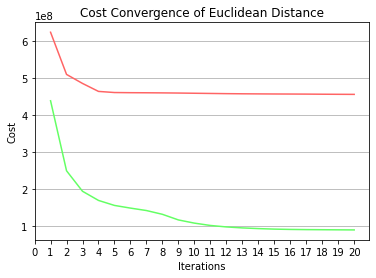

c1            c2
1   6.236603e+08  4.387478e+08
2   5.098629e+08  2.498039e+08
3   4.854807e+08  1.944948e+08
4   4.639970e+08  1.698048e+08
5   4.609693e+08  1.562957e+08
6   4.605378e+08  1.490942e+08
7   4.603131e+08  1.425085e+08
8   4.600035e+08  1.323039e+08
9   4.595705e+08  1.171710e+08
10  4.590211e+08  1.085474e+08
11  4.584907e+08  1.022372e+08
12  4.579442e+08  9.827802e+07
13  4.575580e+08  9.563023e+07
14  4.572901e+08  9.379331e+07
15  4.570506e+08  9.237713e+07
16  4.568922e+08  9.154161e+07
17  4.567036e+08  9.104557e+07
18  4.564042e+08  9.075224e+07
19  4.561778e+08  9.047017e+07
20  4.559869e+08  9.021642e+07

C1 percentage Improvement: 26.885%
C2 percentage Improvement: 79.438%


In [19]:
cost_c = [cost_c1_e, cost_c2_e, cost_c1_m, cost_c2_m]
cen_list = [c1_euclidean, c2_euclidean, c1_manhattan, c2_manhattan]


generate_graph(cost_c[0:2], 'Euclidean')
generate_table(cost_c[0:2])
print("C1 percentage Improvement: {:.3%}".format(abs(cost_c[0][19] - cost_c[0][0]) / cost_c[0][0]))
print("C2 percentage Improvement: {:.3%}".format(abs(cost_c[1][19] - cost_c[1][0]) / cost_c[1][0]))

In [20]:
def euc_dist_sqrt(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))
def man_dist(p1, p2):
    return sum(abs(a - b) for a, b in zip(p1, p2))
generate_cen_table(cen_list[0], euc_dist_sqrt)
generate_cen_table(cen_list[0], man_dist)
generate_cen_table(cen_list[1], euc_dist_sqrt)
generate_cen_table(cen_list[1], man_dist)

1        2         3         4         5         6         7         8   \
1   0.0  692.158  3490.259    205.75   346.719   512.612   444.731   566.202   
2            0.0  2798.801   897.659  1038.827  1204.078  1136.327   1257.45   
3                      0.0  3695.114  3836.907  4002.689  3934.872  4056.136   
4                                0.0   142.439   309.506    241.73   363.263   
5                                          0.0    167.15    99.546   220.902   
6                                                    0.0    67.912     53.79   
7                                                              0.0   121.634   
8                                                                        0.0   
9                                                                              
10                                                                             

          9         10  
1   1282.771   307.669  
2     669.89   412.076  
3    2294.58  3195.924  
4   1474.945   504.634  
5   1615.852   646.931  
6   1782.203   814.076  
7   1715.253   746.336  
8    1835.64   867.823  
9        0.0   975.320  
10               0.000

1        2         3         4         5         6         7         8   \
1   0.0  728.924  3797.899   212.181    374.89   577.402   499.158    645.77   
2            0.0  3072.889   935.885  1100.833  1303.896  1225.352  1372.092   
3                      0.0  4001.038  4170.305  4372.789  4294.953   4440.72   
4                                0.0   171.365   375.248   296.255   443.498   
5                                          0.0   204.523   125.597   272.935   
6                                                    0.0    79.402     69.59   
7                                                              0.0   147.866   
8                                                                        0.0   
9                                                                              
10                                                                             

          9         10  
1   1731.064   406.701  
2   1005.293   490.928  
3   2513.423  3396.420  
4   1934.087   609.749  
5   2102.865   779.397  
6    2306.38   983.020  
7   2227.556   904.370  
8   2374.545  1050.916  
9        0.0  1327.584  
10               0.000

1          2          3         4          5          6          7   \
1   0.0  15760.122  14110.834   9045.32   5567.685   1924.624   1100.859   
2              0.0  11524.506  6743.884  10192.525  14455.119  14682.451   
3                         0.0  9545.879  10883.382   12233.96  13208.003   
4                                   0.0   3494.222   7718.222   7957.776   
5                                              0.0   4404.563   4492.458   
6                                                         0.0   1182.864   
7                                                                    0.0   
8                                                                          
9                                                                          
10                                                                         

           8          9          10  
1     402.891   2105.443   3169.004  
2   15362.418  13674.708  12597.040  
3   13786.484  12508.957  11938.376  
4    8644.807   6947.821   5876.330  
5    5169.937   3488.159   2407.919  
6    1615.788   1313.327   2153.771  
7     698.488   1010.198   2085.461  
8         0.0   1702.793   2768.608  
9                    0.0   1080.535  
10                            0.000

1          2          3          4          5          6          7   \
1   0.0  15772.615  20215.646   9533.171     5604.2   3088.054   1311.039   
2              0.0  16003.499   7219.197  10221.031  16105.347   14909.17   
3                         0.0  10690.484  14613.552  17509.903  18912.605   
4                                    0.0   3935.293   8896.389   8228.355   
5                                               0.0    5893.07   4696.975   
6                                                          0.0   1781.823   
7                                                                     0.0   
8                                                                           
9                                                                           
10                                                                          

           8          9          10  
1     471.266   2369.412   3349.657  
2    15434.46  13950.576  12776.883  
3   19748.936  17851.807  16873.244  
4    9065.404   7168.733   6190.679  
5    5221.253   3737.707   2564.171  
6    2619.811   2162.802   3337.746  
7     840.723    1068.94   2137.788  
8         0.0   1901.209   2883.735  
9                    0.0   1176.450  
10                            0.000

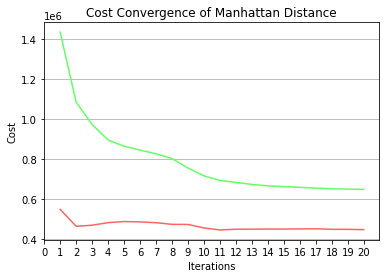

c1            c2
1   550117.142000  1.433739e+06
2   465617.348524  1.084489e+06
3   470902.296501  9.734317e+05
4   483932.393169  8.959346e+05
5   489207.575817  8.651283e+05
6   487597.673861  8.458466e+05
7   483507.394469  8.272196e+05
8   475258.866664  8.035903e+05
9   474863.623920  7.560395e+05
10  457210.606910  7.173329e+05
11  447522.406734  6.945879e+05
12  450872.486771  6.844445e+05
13  451157.792612  6.745747e+05
14  451922.281166  6.674095e+05
15  451572.946852  6.635566e+05
16  452744.142800  6.601628e+05
17  453082.730287  6.560413e+05
18  450583.670860  6.530368e+05
19  450368.749317  6.511124e+05
20  449011.363726  6.496890e+05

C1 percentage Improvement: 18.379%
C2 percentage Improvement: 54.686%


In [21]:
generate_graph(cost_c[2:4], 'Manhattan')
generate_table(cost_c[2:4])
print("C1 percentage Improvement: {:.3%}".format(abs(cost_c[2][19] - cost_c[2][0]) / cost_c[2][0]))
print("C2 percentage Improvement: {:.3%}".format(abs(cost_c[3][19] - cost_c[3][0]) / cost_c[3][0]))

In [22]:
generate_cen_table(cen_list[2], euc_dist_sqrt)
generate_cen_table(cen_list[2], man_dist)
generate_cen_table(cen_list[3], euc_dist_sqrt)
generate_cen_table(cen_list[3], man_dist)

1         2         3          4          5          6          7   \
1   0.0  2219.177  9948.044      528.7    413.365    827.719    681.035   
2             0.0  7767.946    2734.05   2628.491   3044.478   2898.713   
3                       0.0  10433.061  10361.367  10773.531  10626.489   
4                                  0.0    221.373    375.156    249.379   
5                                             0.0     415.99    270.749   
6                                                        0.0    147.047   
7                                                                   0.0   
8                                                                         
9                                                                         
10                                                                        

           8         9         10  
1     917.127   832.147   729.056  
2     3133.46  1812.455  1491.357  
3   10862.966  9340.275  9236.840  
4      457.26  1156.583  1251.158  
5     505.071  1171.964  1137.135  
6      89.491  1529.464  1553.124  
7     236.515   1391.55  1407.404  
8         0.0  1613.556  1642.129  
9                   0.0   709.408  
10                          0.000

1         2         3          4          5          6          7   \
1   0.0  2341.017   11929.3    651.187    496.332    947.743    770.737   
2             0.0  9597.441   2778.946   2830.145   3280.359   3104.286   
3                       0.0  12323.288  12421.263  12871.483  12695.554   
4                                  0.0    335.951    558.469    382.463   
5                                             0.0    452.861    276.326   
6                                                        0.0    177.593   
7                                                                   0.0   
8                                                                         
9                                                                         
10                                                                        

           8          9          10  
1      1056.8   1260.511    737.714  
2    3388.983   2380.461   1605.270  
3   12979.133  10775.939  11196.787  
4     667.533   1653.826   1379.165  
5     561.849   1755.106   1226.660  
6     110.218   2205.307   1677.667  
7      287.43   2028.902   1500.993  
8         0.0   2314.667   1786.811  
9                    0.0   1006.368  
10                            0.000

1          2          3         4          5          6          7   \
1   0.0  15747.234  14100.145  9032.333   5554.787   2006.703   1338.161   
2              0.0  11524.506  6743.884  10192.525  14474.554  14412.057   
3                         0.0  9545.879  10883.382  12167.794  13125.351   
4                                   0.0   3494.222   7742.628   7694.277   
5                                              0.0   4452.972   4219.761   
6                                                         0.0   1405.109   
7                                                                    0.0   
8                                                                          
9                                                                          
10                                                                         

           8          9          10  
1     514.627   1571.243   3022.661  
2   15239.877  14328.226  12731.398  
3   13684.607  12643.986  12006.395  
4    8521.198   7588.405   6009.820  
5    5047.516   4167.637   2542.569  
6    1637.729    910.994   2124.263  
7     827.841    566.551   1684.516  
8         0.0   1081.379   2511.459  
9                    0.0   1649.389  
10                            0.000

1          2          3          4          5          6          7   \
1   0.0  15757.691  20200.259   9517.668   5588.854   3281.488   1430.209   
2              0.0  16003.499   7219.197  10221.031  16325.271  14506.486   
3                         0.0  10690.484  14613.552  17521.518  18775.121   
4                                    0.0   3935.293   9116.024    8090.51   
5                                               0.0   6110.833   4293.502   
6                                                          0.0    1855.58   
7                                                                     0.0   
8                                                                           
9                                                                           
10                                                                          

           8          9          10  
1     602.955   2102.554   3211.456  
2   15335.957  14980.056  12922.931  
3   19602.263  18111.885  16995.134  
4    8918.813   7771.222   6312.530  
5    5123.067   4768.923   2710.056  
6    2682.569   1358.796   3413.036  
7      833.43    674.828   1784.512  
8         0.0   1500.825   2613.997  
9                    0.0   2062.251  
10                            0.000